# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [1]:
# relevant imports
import os
from torch import nn, optim
from torchsummary import summary
from datasets import load_dataset
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from ray import tune
from functools import partial
from ray.air import session
from ray.train import Checkpoint
from monai.losses import DiceLoss
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import torch
from monai.metrics import MeanIoU
from monai.transforms import Activations, AsDiscrete


#### Modelarchitecture
![unet_brain_mri.png](https://pytorch.org/assets/images/unet_brain_mri.png)

In [2]:
class UNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = UNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_2 = UNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_3 = UNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_4 = UNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottle_neck_block = UNet._conv_block(256, 512)

        # Decoder Blocks
        self.upconv_block_4 = UNet._upconv_block(512, 256)
        self.decoder_block_4 = UNet._conv_block(512, 256)

        self.upconv_block_3 = UNet._upconv_block(256, 128)
        self.decoder_block_3 = UNet._conv_block(256, 128)

        self.upconv_block_2 = UNet._upconv_block(128, 64)
        self.decoder_block_2 = UNet._conv_block(128, 64)

        self.upconv_block_1 = UNet._upconv_block(64, 32)
        self.decoder_block_1 = UNet._conv_block(64, 32)

        # Output convolution
        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e2 = self.encoder_block_2(self.max_pool_1(e1))
        e3 = self.encoder_block_3(self.max_pool_2(e2))
        e4 = self.encoder_block_4(self.max_pool_3(e3))

        b = self.bottle_neck_block(self.max_pool_4(e4))

        d4 = self.upconv_block_4(b)
        d4 = self.decoder_block_4(torch.cat((d4, e4), dim=1))
        d3 = self.upconv_block_3(d4)
        d3 = self.decoder_block_3(torch.cat((d3, e3), dim=1))
        d2 = self.upconv_block_2(d3)
        d2 = self.decoder_block_2(torch.cat((d2, e2), dim=1))
        d1 = self.upconv_block_1(d2)
        d1 = self.decoder_block_1(torch.cat((d1, e1), dim=1))

        return self.fc(d1)

    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

    @staticmethod
    def _upconv_block(input_size, output_size):
        return nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2)

In [3]:
# Load U-Net
unet = UNet(3, 1)
unet.cuda()
summary(unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

---

#### Datapreparation

In [3]:
isic18_dataset = load_dataset("surajbijjahalli/ISIC2018")
isic18_dataset

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [4]:
class ISICDataset(Dataset):
    def __init__(self, dataset, transform_image=None, transform_mask=None):
        self.dataset = dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image = example['image']
        mask = example['label']
        mask = mask.convert('L')
        mask = np.array(mask)
        mask[mask > 0] = 255
        mask[mask == 0] = 0
        mask = Image.fromarray(mask)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()])

isic18_train_dataset = ISICDataset(isic18_dataset['train'], transform_image, transform_mask)
isic18_val_dataset = ISICDataset(isic18_dataset['validation'], transform_image, transform_mask)
isic18_test_dataset = ISICDataset(isic18_dataset['test'], transform_image, transform_mask)

---

#### Training

In [7]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss


In [8]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss


In [11]:
def train_unet(
        config: dict,
        train_dataset: datasets,
        validation_dataset: datasets,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = UNet(3, 1).to(device)

    loss_fn = DiceLoss(sigmoid=True)

    optim_params: dict = {
        'lr': config["lr"]
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

    scheduler_params: dict = {
        'gamma': config['gamma'],
        'verbose': False
    }
    scheduler: ExponentialLR = ExponentialLR(optimizer, **scheduler_params)

    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint1.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Parametertuning

In [ ]:
EPOCHS = 20
partial_model_train = partial(train_unet, epochs=EPOCHS)

config = {
    "lr": tune.loguniform(1e-4, 1e0),
    "gamma": tune.uniform(0.9, 0.99999),
}


tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(partial_model_train,
                                 train_dataset=isic18_train_dataset,
                                 validation_dataset=isic18_val_dataset),
            resources={"GPU": 1}),

        tune_config=tune.TuneConfig(metric="val_loss",
                                    mode="min",
                                    num_samples=5),

        param_space=config)

In [ ]:
results = tuner.fit()

---

#### Training with Parameter

In [ ]:
best_trial = results.get_best_result("val_loss", "min", "last")
best_trial.config

In [12]:
config = {'lr': 0.0011075820407299578, 'gamma': 0.9596539000640568}

res = train_unet(config, isic18_train_dataset, isic18_val_dataset, 50, return_flag=True, apply_scheduler=True)

cuda:6
Start training...


  0%|          | 0/50 [00:00<?, ?it/s]

Start:  0


/home/jovyan/.local/lib/python3.11/site-packages/ray/train/_internal/session.py:652: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(
  2%|▏         | 1/50 [02:23<1:57:21, 143.70s/it]

0  -  tr_loss: 0.5715606408875163 val_loss: 0.4630175828933716
Start:  1
1  -  tr_loss: 0.4886630075733836 val_loss: 0.4417276084423065


  4%|▍         | 2/50 [04:39<1:51:14, 139.06s/it]

Start:  2
2  -  tr_loss: 0.41741068552180033 val_loss: 0.4018860161304474


  6%|▌         | 3/50 [07:15<1:54:49, 146.59s/it]

Start:  3
3  -  tr_loss: 0.3544578196071997 val_loss: 0.3274059146642685


  8%|▊         | 4/50 [09:49<1:54:37, 149.51s/it]

Start:  4
4  -  tr_loss: 0.30623177675212304 val_loss: 0.27300800383090973


 10%|█         | 5/50 [12:22<1:53:09, 150.88s/it]

Start:  5
5  -  tr_loss: 0.26108042677728144 val_loss: 0.3761734664440155


 12%|█▏        | 6/50 [14:43<1:48:08, 147.46s/it]

Start:  6
6  -  tr_loss: 0.23891668239744698 val_loss: 0.21281910687685013


 14%|█▍        | 7/50 [17:37<1:52:00, 156.28s/it]

Start:  7
7  -  tr_loss: 0.21423925386696327 val_loss: 0.18763399124145508


 16%|█▌        | 8/50 [20:07<1:48:03, 154.38s/it]

Start:  8
8  -  tr_loss: 0.1975753143793199 val_loss: 0.20377017557621002


 18%|█▊        | 9/50 [22:28<1:42:28, 149.96s/it]

Start:  9
9  -  tr_loss: 0.19191577921553357 val_loss: 0.19378076493740082


 20%|██        | 10/50 [24:50<1:38:23, 147.58s/it]

Start:  10
10  -  tr_loss: 0.17587565503469327 val_loss: 0.17934611439704895


 22%|██▏       | 11/50 [27:18<1:36:01, 147.74s/it]

Start:  11
11  -  tr_loss: 0.1675593111573196 val_loss: 0.18757011741399765


 24%|██▍       | 12/50 [29:47<1:33:48, 148.11s/it]

Start:  12
12  -  tr_loss: 0.16354101714564534 val_loss: 0.15905733406543732


 26%|██▌       | 13/50 [32:01<1:28:44, 143.90s/it]

Start:  13
13  -  tr_loss: 0.15896074164931367 val_loss: 0.2095867320895195


 28%|██▊       | 14/50 [34:22<1:25:48, 143.01s/it]

Start:  14
14  -  tr_loss: 0.15407088616999184 val_loss: 0.15936443954706192


 30%|███       | 15/50 [37:06<1:27:09, 149.41s/it]

Start:  15
15  -  tr_loss: 0.1542054162156291 val_loss: 0.17072578519582748


 32%|███▏      | 16/50 [39:45<1:26:10, 152.08s/it]

Start:  16
16  -  tr_loss: 0.15284236447840202 val_loss: 0.16778647154569626


 34%|███▍      | 17/50 [42:15<1:23:22, 151.58s/it]

Start:  17
17  -  tr_loss: 0.14566410496467497 val_loss: 0.16589133441448212


 36%|███▌      | 18/50 [44:29<1:17:58, 146.21s/it]

Start:  18
18  -  tr_loss: 0.14372389600044344 val_loss: 0.1561160534620285


 38%|███▊      | 19/50 [46:43<1:13:38, 142.54s/it]

Start:  19
19  -  tr_loss: 0.14165343162490102 val_loss: 0.15805844217538834


 40%|████      | 20/50 [49:20<1:13:25, 146.86s/it]

Start:  20
20  -  tr_loss: 0.14014211624133877 val_loss: 0.17907243967056274


 42%|████▏     | 21/50 [51:38<1:09:41, 144.20s/it]

Start:  21
21  -  tr_loss: 0.14022215183188275 val_loss: 0.1852896586060524


 44%|████▍     | 22/50 [53:57<1:06:32, 142.61s/it]

Start:  22
22  -  tr_loss: 0.13480866446000775 val_loss: 0.16854491084814072


 46%|████▌     | 23/50 [56:38<1:06:42, 148.25s/it]

Start:  23
23  -  tr_loss: 0.13015653901710744 val_loss: 0.1608055979013443


 48%|████▊     | 24/50 [58:55<1:02:46, 144.86s/it]

Start:  24
24  -  tr_loss: 0.13151325667049826 val_loss: 0.16588982939720154


 50%|█████     | 25/50 [1:01:19<1:00:12, 144.50s/it]

Start:  25
25  -  tr_loss: 0.1271362758991195 val_loss: 0.16047441959381104


 52%|█████▏    | 26/50 [1:03:36<56:56, 142.34s/it]  

Start:  26
26  -  tr_loss: 0.12566755675688024 val_loss: 0.1575712412595749


 54%|█████▍    | 27/50 [1:05:57<54:23, 141.91s/it]

Start:  27
27  -  tr_loss: 0.12285145808283876 val_loss: 0.14873886108398438


 56%|█████▌    | 28/50 [1:08:26<52:50, 144.10s/it]

Start:  28
28  -  tr_loss: 0.12636212295875315 val_loss: 0.15263518691062927


 58%|█████▊    | 29/50 [1:10:41<49:27, 141.31s/it]

Start:  29
29  -  tr_loss: 0.1202478932171333 val_loss: 0.1508438065648079


 60%|██████    | 30/50 [1:13:00<46:53, 140.66s/it]

Start:  30
30  -  tr_loss: 0.12076821069164974 val_loss: 0.163896843791008


 62%|██████▏   | 31/50 [1:15:43<46:37, 147.24s/it]

Start:  31
31  -  tr_loss: 0.12007384183930188 val_loss: 0.16191885620355606


 64%|██████▍   | 32/50 [1:18:25<45:30, 151.67s/it]

Start:  32
32  -  tr_loss: 0.11941478092495988 val_loss: 0.16179994493722916


 66%|██████▌   | 33/50 [1:21:03<43:31, 153.59s/it]

Start:  33
33  -  tr_loss: 0.11635422761120447 val_loss: 0.14720409363508224


 68%|██████▊   | 34/50 [1:23:26<40:07, 150.46s/it]

Start:  34
34  -  tr_loss: 0.11542677861161349 val_loss: 0.14584917575120926


 70%|███████   | 35/50 [1:25:52<37:18, 149.24s/it]

Start:  35
35  -  tr_loss: 0.11759322518255652 val_loss: 0.14660567790269852


 72%|███████▏  | 36/50 [1:28:15<34:23, 147.43s/it]

Start:  36
36  -  tr_loss: 0.11352783296166397 val_loss: 0.14600874483585358


 74%|███████▍  | 37/50 [1:30:30<31:07, 143.68s/it]

Start:  37
37  -  tr_loss: 0.11619389202536606 val_loss: 0.13754967600107193


 76%|███████▌  | 38/50 [1:33:36<31:14, 156.19s/it]

Start:  38
38  -  tr_loss: 0.11210144565599721 val_loss: 0.13995040953159332


 78%|███████▊  | 39/50 [1:35:59<27:53, 152.17s/it]

Start:  39
39  -  tr_loss: 0.11190304323667433 val_loss: 0.14386480301618576


 80%|████████  | 40/50 [1:38:34<25:30, 153.06s/it]

Start:  40
40  -  tr_loss: 0.111363675172736 val_loss: 0.1497737467288971


 82%|████████▏ | 41/50 [1:40:52<22:18, 148.67s/it]

Start:  41
41  -  tr_loss: 0.10966826139426814 val_loss: 0.14614998549222946


 84%|████████▍ | 42/50 [1:43:23<19:55, 149.47s/it]

Start:  42
42  -  tr_loss: 0.10742057351077475 val_loss: 0.14449705928564072


 86%|████████▌ | 43/50 [1:45:55<17:29, 149.96s/it]

Start:  43
43  -  tr_loss: 0.10915877342951007 val_loss: 0.14111565798521042


 88%|████████▊ | 44/50 [1:48:32<15:13, 152.22s/it]

Start:  44
44  -  tr_loss: 0.10582764228669608 val_loss: 0.1428251415491104


 90%|█████████ | 45/50 [1:51:03<12:38, 151.78s/it]

Start:  45
45  -  tr_loss: 0.10524699927830114 val_loss: 0.13645592331886292


 92%|█████████▏| 46/50 [1:53:18<09:47, 146.77s/it]

Start:  46
46  -  tr_loss: 0.1083886510715252 val_loss: 0.14767494797706604


 94%|█████████▍| 47/50 [1:55:32<07:08, 142.89s/it]

Start:  47
47  -  tr_loss: 0.10537549162783273 val_loss: 0.14594712108373642


 96%|█████████▌| 48/50 [1:58:01<04:49, 144.94s/it]

Start:  48
48  -  tr_loss: 0.10446354583269213 val_loss: 0.13840112835168839


 98%|█████████▊| 49/50 [2:00:31<02:26, 146.37s/it]

Start:  49
49  -  tr_loss: 0.10347487523061473 val_loss: 0.1393211930990219


100%|██████████| 50/50 [2:02:47<00:00, 147.35s/it]


In [13]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

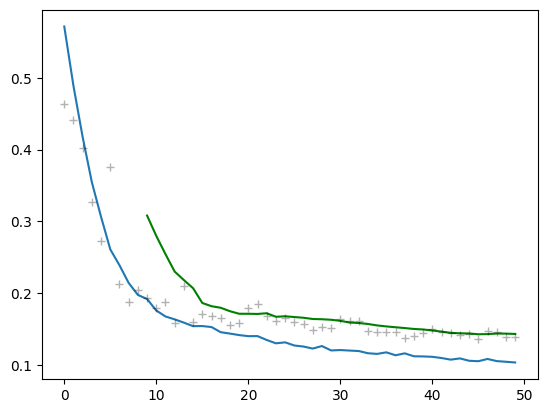

In [14]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [18]:
torch.save(model, '../../res/checkpoints/unet_isic18_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/unet_isic18.pt')

In [6]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [7]:
test_dataloader = DataLoader(isic18_test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = UNet(3, 1).to(device)

net = load_checkpoint(Path('../../res/checkpoints/unet_isic18.pt'), net)

In [11]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy for binary segmentation.
    :param model: neural network
    :param data_loader: torch Dataloader
    :param device: device on which to perform the evaluation
    :return: None
    """
    total_correct_pixels = 0
    total_pixels = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).cpu().numpy()

            targets = targets.numpy().flatten()
            preds = preds.flatten()

            correct_pixels = np.sum(preds == targets)
            total_pixels += targets.size
            total_correct_pixels += correct_pixels

    pixel_accuracy = total_correct_pixels / total_pixels
    print('Pixel Accuracy: ', pixel_accuracy)

In [12]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 16/16 [02:52<00:00, 10.79s/it]

Pixel Accuracy:  0.911911636352539


In [16]:
def evaluate_binary_mean_iou(model, dataloader, device) -> float:
    """
    Evaluate the Mean IoU for binary segmentation.
    :param model: neural network
    :param dataloader: Torch Dataloader
    :param device: device on which to perform the evaluation
    :return: mean IoU
    """
    mean_iou_metric = MeanIoU(include_background=True, reduction="mean")
    activation = Activations(sigmoid=True)
    discretize = AsDiscrete(threshold=0.5)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            preds = activation(outputs)
            preds = discretize(preds)

            mean_iou_metric(y_pred=preds, y=targets)

    mean_iou = mean_iou_metric.aggregate().item()
    print(f"Mean IoU: {mean_iou}")
    return mean_iou


In [17]:
evaluate_binary_mean_iou(net, test_dataloader, device)

100%|██████████| 16/16 [02:44<00:00, 10.30s/it]

Mean IoU: 0.7671493887901306


0.7671493887901306